display one set of data in the data set


Mounted at /content/drive


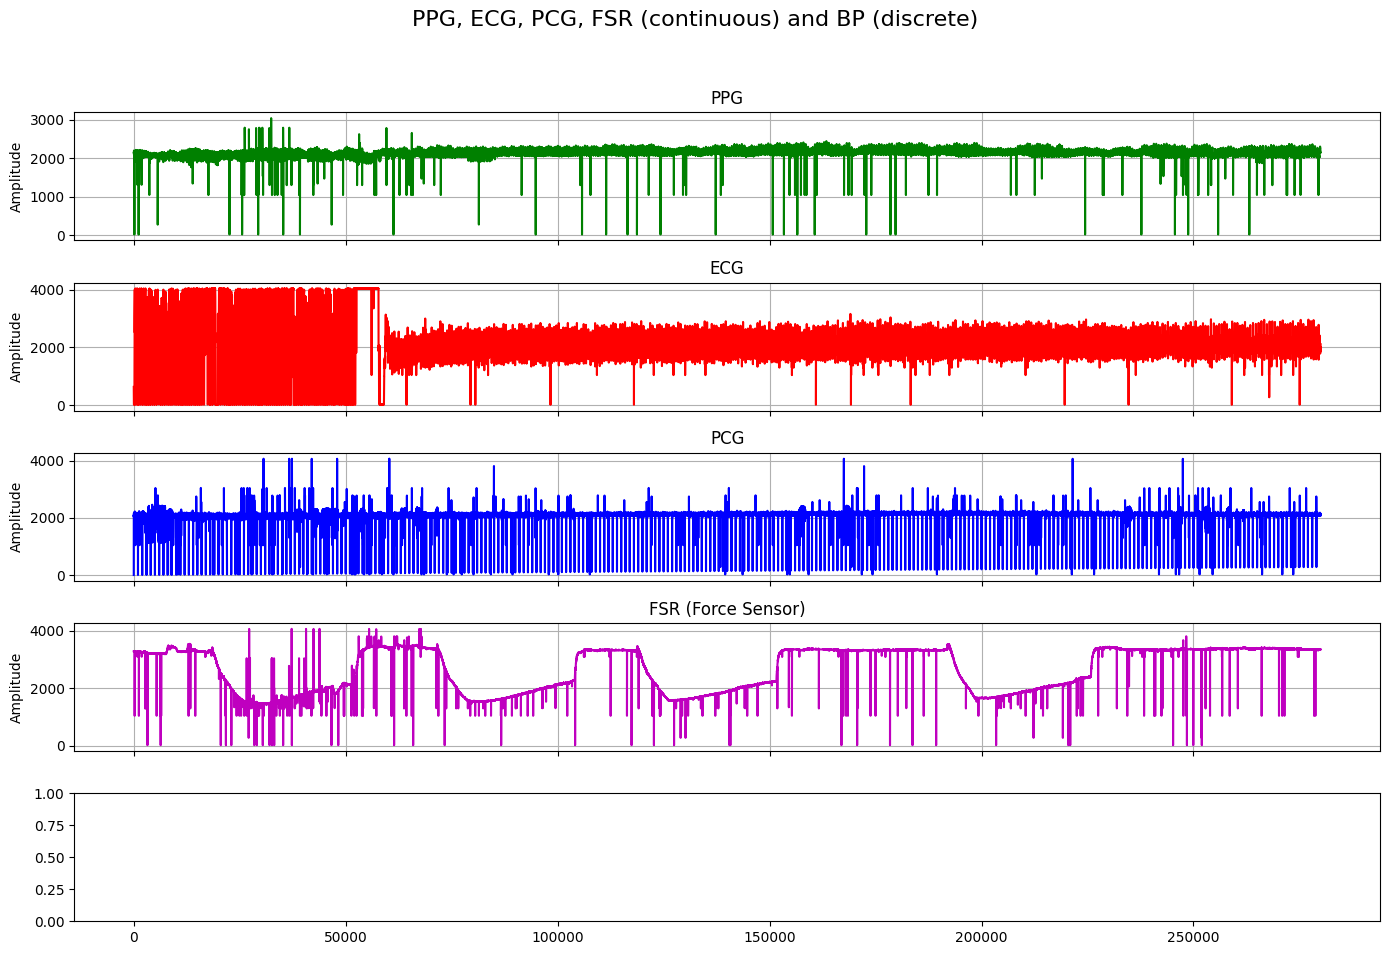

In [ ]:
# === RUN THIS CELL FIRST ===

import json
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')



# Get filename (only one file expected)
filename = "/content/drive/My Drive/Data/data/1.json"


# Load JSON data
with open(filename, 'r') as f:
    data = json.load(f)

# Extract signals
ppg = np.array(data['data_PPG'])
ecg = np.array(data['data_ECG'])
pcg = np.array(data['data_PCG'])
fsr = np.array(data['data_FSR'])
bp = np.array(data['data_BP'])

# Determine minimum common length for continuous signals
max_len = min(len(ppg), len(ecg), len(pcg), len(fsr))
t = np.arange(1, max_len + 1)

# Trim signals
ppg = ppg[:max_len]
ecg = ecg[:max_len]
pcg = pcg[:max_len]
fsr = fsr[:max_len]

# Plot
fig, axs = plt.subplots(5, 1, figsize=(14, 10), sharex=True)
fig.suptitle('PPG, ECG, PCG, FSR (continuous) and BP (discrete)', fontsize=16)

axs[0].plot(t, ppg, 'g')
axs[0].set_title('PPG')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

axs[1].plot(t, ecg, 'r')
axs[1].set_title('ECG')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)

axs[2].plot(t, pcg, 'b')
axs[2].set_title('PCG')
axs[2].set_ylabel('Amplitude')
axs[2].grid(True)

axs[3].plot(t, fsr, 'm')
axs[3].set_title('FSR (Force Sensor)')
axs[3].set_ylabel('Amplitude')
axs[3].grid(True)




plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


PPG preprocessed with Exponential weight filter

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


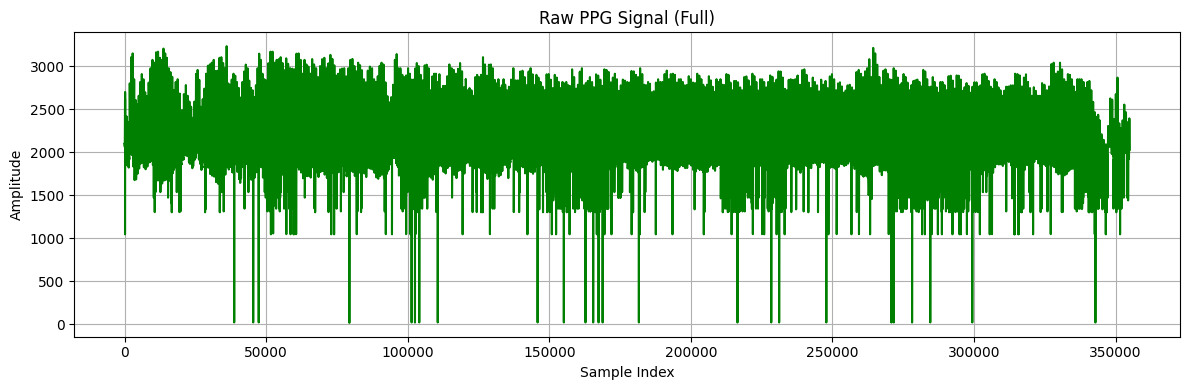

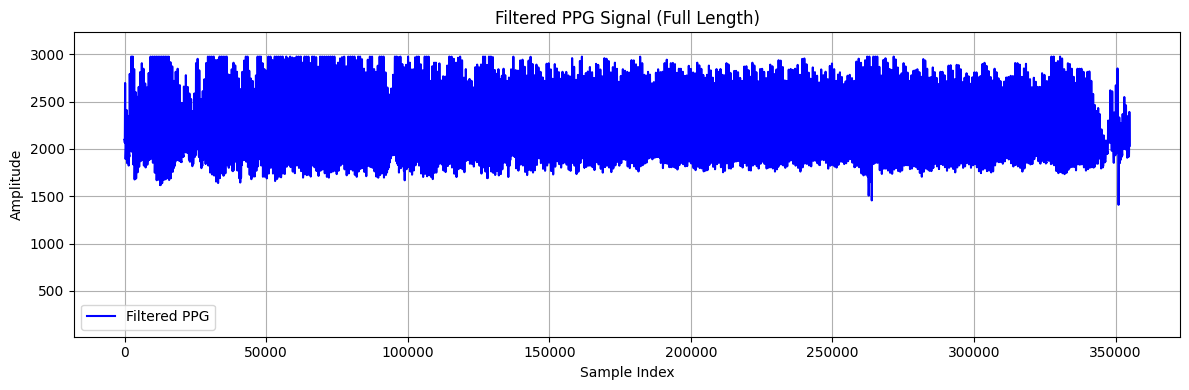

interactive(children=(IntSlider(value=354000, description='ZOOM_START', max=354000, step=1000), IntSlider(valu…

SNR between raw and filtered PPG: 35.07 dB


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import pandas as pd
from ipywidgets import interact, IntSlider

def calculate_snr(raw, filtered):
    noise = raw - filtered
    power_signal = np.mean(filtered ** 2)
    power_noise = np.mean(noise ** 2)
    snr = 10 * np.log10(power_signal / power_noise)
    return snr

# === Mount Google Drive ===
drive.mount('/content/drive')

# === Load JSON File ===
filename = "/content/drive/My Drive/Data/data/15.json"
with open(filename, 'r') as f:
    data = json.load(f)

# === Extract Signals ===
ppg = data['data_PPG']
ecg = data['data_ECG']
pcg = data['data_PCG']
fsr = data['data_FSR']

# === Compute minimum common length ===
max_len = min(len(ppg), len(ecg), len(pcg), len(fsr))
ppg = np.array(ppg[:max_len])
t = np.arange(max_len)

# === Parameters ===
CLIP_STD = 3.0
DELTA_FACTOR = 0.25
SPAN = 4

# === Step 1: Plot Raw PPG (Full) ===
plt.figure(figsize=(12, 4))
plt.plot(t, ppg, color='green', label='Raw PPG')
plt.title('Raw PPG Signal (Full)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 2: Clip outliers ===
mean = np.nanmean(ppg)
std = np.nanstd(ppg)
high_clip = mean + CLIP_STD * std
low_clip = mean - CLIP_STD * std
ppg_clipped = np.where((ppg > high_clip) | (ppg < low_clip), np.nan, ppg)

# === Step 3: Forward-Backward EWMA ===
fwd = pd.Series(ppg_clipped).ewm(span=SPAN).mean()
bwd = pd.Series(ppg_clipped[::-1]).ewm(span=SPAN).mean()
fb_ewma = np.nanmean(np.vstack((fwd, bwd[::-1])), axis=0)

# === Step 4: Spike Detection and Removal ===
delta = DELTA_FACTOR * std
mask_spike = np.abs(ppg_clipped - fb_ewma) > delta
ppg_denoised = np.where(mask_spike, np.nan, ppg_clipped)

# === Step 5: Interpolation ===
ppg_cleaned = pd.Series(ppg_denoised).interpolate().to_numpy()

# === Step 6: Second-pass EWMA smoothing ===
ppg_cleaned_smoothed = pd.Series(ppg_cleaned).ewm(span=8).mean().to_numpy()

# === Step 7: Filtered Signal Plot (Full) ===
plt.figure(figsize=(12, 4))
plt.plot(t, ppg_cleaned_smoothed, label='Filtered PPG', color='blue')
plt.ylim(np.min(ppg), np.max(ppg))
plt.title('Filtered PPG Signal (Full Length)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 8: Interactive Zoom & Comparison ===
def interactive_zoom(ZOOM_START=550000, ZOOM_WIDTH=5000):
    ZOOM_END = min(ZOOM_START + ZOOM_WIDTH, len(ppg))
    zoom_range = np.arange(ZOOM_START, ZOOM_END)

    # --- Combined Plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(zoom_range, ppg[ZOOM_START:ZOOM_END], label='Raw PPG', color='green', alpha=0.5)
    plt.plot(zoom_range, ppg_cleaned_smoothed[ZOOM_START:ZOOM_END], label='Filtered PPG', color='blue')
    plt.title(f'Zoomed-In PPG Region ({ZOOM_START} to {ZOOM_END})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Side-by-Side Comparison ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    axs[0].plot(zoom_range, ppg[ZOOM_START:ZOOM_END], color='green')
    axs[0].set_title('Raw PPG (Zoomed)')
    axs[0].set_xlabel('Sample Index')
    axs[0].set_ylabel('Amplitude')
    axs[0].grid(True)

    axs[1].plot(zoom_range, ppg_cleaned_smoothed[ZOOM_START:ZOOM_END], color='blue')
    axs[1].set_title('Filtered PPG (Zoomed)')
    axs[1].set_xlabel('Sample Index')
    axs[1].grid(True)

    fig.suptitle(f'Comparison: Raw vs Filtered PPG ({ZOOM_START}-{ZOOM_END})', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# === Sliders ===
interact(
    interactive_zoom,
    ZOOM_START=IntSlider(min=0, max=max_len - 1000, step=1000, value=550000),
    ZOOM_WIDTH=IntSlider(min=1000, max=20000, step=1000, value=5000)
)

snr_value = calculate_snr(ppg, ppg_cleaned_smoothed)
print(f"SNR between raw and filtered PPG: {snr_value:.2f} dB")


PPG preprocessed with median filter and savisky golay filter

Mounted at /content/drive


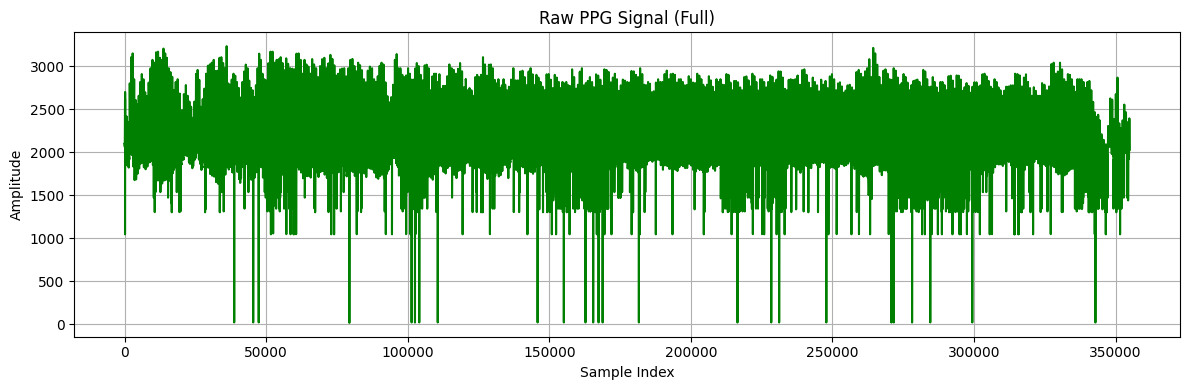

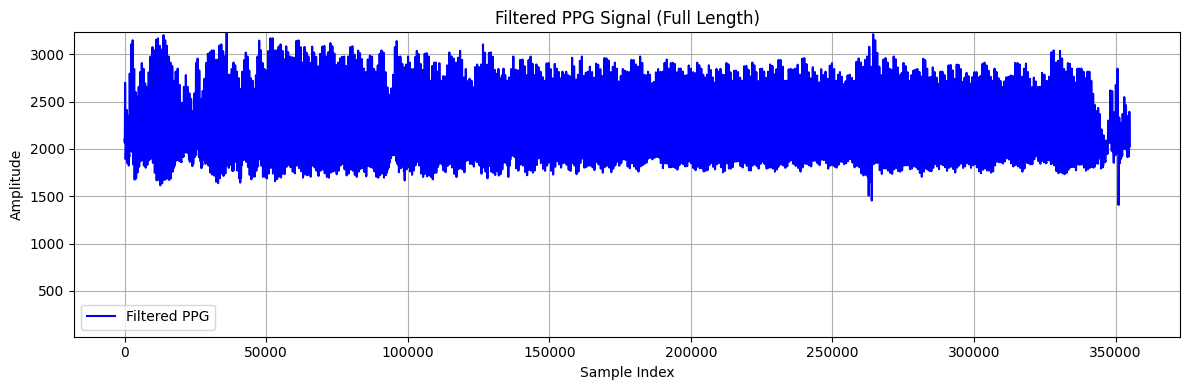

interactive(children=(IntSlider(value=354000, description='ZOOM_START', max=354000, step=1000), IntSlider(valu…

SNR between raw and filtered PPG: 36.83 dB


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import pandas as pd
from ipywidgets import interact, IntSlider
from scipy.signal import medfilt, savgol_filter

def calculate_snr(raw, filtered):
    noise = raw - filtered
    power_signal = np.mean(filtered ** 2)
    power_noise = np.mean(noise ** 2)
    snr = 10 * np.log10(power_signal / power_noise)
    return snr


# === Mount Google Drive ===
drive.mount('/content/drive')

# === Load JSON File ===
filename = "/content/drive/My Drive/Data/data/15.json"
with open(filename, 'r') as f:
    data = json.load(f)

# === Extract Signals ===
ppg = data['data_PPG']
ecg = data['data_ECG']
pcg = data['data_PCG']
fsr = data['data_FSR']

# === Compute minimum common length ===
max_len = min(len(ppg), len(ecg), len(pcg), len(fsr))
ppg = np.array(ppg[:max_len])
t = np.arange(max_len)

# === Step 1: Plot Raw PPG (Full) ===
plt.figure(figsize=(12, 4))
plt.plot(t, ppg, color='green', label='Raw PPG')
plt.title('Raw PPG Signal (Full)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 2: Apply Median Filter to Remove Narrow Spikes ===
ppg_median = medfilt(ppg, kernel_size=7)

# === Step 3: Apply Savitzky–Golay Filter to Smooth While Preserving Peaks ===
ppg_filtered = savgol_filter(ppg_median, window_length=15, polyorder=2)

# === Step 4: Plot Filtered Signal (Full Length) ===
plt.figure(figsize=(12, 4))
plt.plot(t, ppg_filtered, label='Filtered PPG', color='blue')
plt.ylim(np.min(ppg), np.max(ppg))
plt.title('Filtered PPG Signal (Full Length)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 5: Interactive Zoom & Comparison ===
def interactive_zoom(ZOOM_START=550000, ZOOM_WIDTH=5000):
    ZOOM_END = min(ZOOM_START + ZOOM_WIDTH, len(ppg))
    zoom_range = np.arange(ZOOM_START, ZOOM_END)

    # --- Combined Plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(zoom_range, ppg[ZOOM_START:ZOOM_END], label='Raw PPG', color='green', alpha=0.5)
    plt.plot(zoom_range, ppg_filtered[ZOOM_START:ZOOM_END], label='Filtered PPG', color='blue')
    plt.title(f'Zoomed-In PPG Region ({ZOOM_START} to {ZOOM_END})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Side-by-Side Comparison ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    axs[0].plot(zoom_range, ppg[ZOOM_START:ZOOM_END], color='green')
    axs[0].set_title('Raw PPG (Zoomed)')
    axs[0].set_xlabel('Sample Index')
    axs[0].set_ylabel('Amplitude')
    axs[0].grid(True)

    axs[1].plot(zoom_range, ppg_filtered[ZOOM_START:ZOOM_END], color='blue')
    axs[1].set_title('Filtered PPG (Zoomed)')
    axs[1].set_xlabel('Sample Index')
    axs[1].grid(True)

    fig.suptitle(f'Comparison: Raw vs Filtered PPG ({ZOOM_START}-{ZOOM_END})', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# === Sliders ===
interact(
    interactive_zoom,
    ZOOM_START=IntSlider(min=0, max=max_len - 1000, step=1000, value=550000),
    ZOOM_WIDTH=IntSlider(min=1000, max=20000, step=1000, value=5000)
)

snr_value = calculate_snr(ppg, ppg_filtered)
print(f"SNR between raw and filtered PPG: {snr_value:.2f} dB")

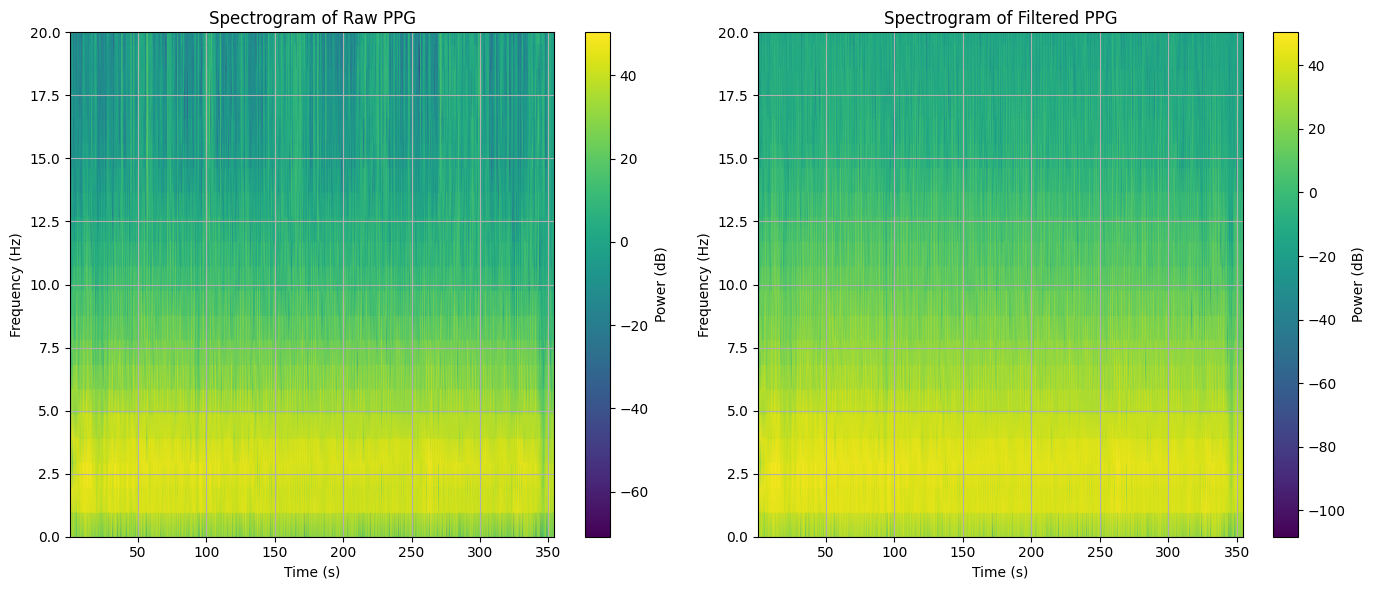

In [ ]:
from scipy.signal import spectrogram

# === Step 6: Plot Spectrograms of Raw and Filtered PPG ===
fs = 1000  # Sampling frequency (adjust if different)

# Compute spectrograms
f_raw, t_raw, Sxx_raw = spectrogram(ppg, fs=fs, nperseg=1024, noverlap=512)
f_filt, t_filt, Sxx_filt = spectrogram(ppg_filtered, fs=fs, nperseg=1024, noverlap=512)

# Plot spectrograms
plt.figure(figsize=(14, 6))

# Raw PPG Spectrogram
plt.subplot(1, 2, 1)
plt.pcolormesh(t_raw, f_raw, 10 * np.log10(Sxx_raw), shading='gouraud', cmap='viridis')
plt.title("Spectrogram of Raw PPG")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Power (dB)')
plt.ylim(0, 20)  # Focus on PPG-relevant frequencies
plt.grid(True)

# Filtered PPG Spectrogram
plt.subplot(1, 2, 2)
plt.pcolormesh(t_filt, f_filt, 10 * np.log10(Sxx_filt), shading='gouraud', cmap='viridis')
plt.title("Spectrogram of Filtered PPG")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Power (dB)')
plt.ylim(0, 20)
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import pandas as pd
from ipywidgets import interact, IntSlider
from scipy.signal import medfilt, savgol_filter
from pyPPG.fiducials import FpCollection   # <<--- pyPPG for segmentation

def calculate_snr(raw, filtered):
    noise = raw - filtered
    power_signal = np.mean(filtered ** 2)
    power_noise = np.mean(noise ** 2)
    snr = 10 * np.log10(power_signal / power_noise)
    return snr

# === Mount Google Drive ===
drive.mount('/content/drive')

# === Load JSON File ===
filename = "/content/drive/My Drive/Data/data/15.json"
with open(filename, 'r') as f:
    data = json.load(f)

# === Extract Signals ===
ppg = data['data_PPG']
ecg = data['data_ECG']
pcg = data['data_PCG']
fsr = data['data_FSR']

# === Compute minimum common length ===
max_len = min(len(ppg), len(ecg), len(pcg), len(fsr))
ppg = np.array(ppg[:max_len])
t = np.arange(max_len)

# === Step 1: Plot Raw PPG (Full) ===
plt.figure(figsize=(12, 4))
plt.plot(t, ppg, color='green', label='Raw PPG')
plt.title('Raw PPG Signal (Full)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 2: Apply Median Filter to Remove Narrow Spikes ===
ppg_median = medfilt(ppg, kernel_size=7)

# === Step 3: Apply Savitzky–Golay Filter to Smooth While Preserving Peaks ===
ppg_filtered = savgol_filter(ppg_median, window_length=15, polyorder=2)

# === Step 4: Plot Filtered Signal (Full Length) ===
plt.figure(figsize=(12, 4))
plt.plot(t, ppg_filtered, label='Filtered PPG', color='blue')
plt.ylim(np.min(ppg), np.max(ppg))
plt.title('Filtered PPG Signal (Full Length)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 5: Segment PPG into Beats using pyPPG ===
fs = 100  # <-- set your actual sampling frequency here!
fp = FpCollection(ppg_filtered, fs=fs)
fiducials = fp.get_fiducials(ppg_filtered)

# Extract onset indices
onsets = fiducials['on'].dropna().astype(int).values

# Slice beats onset-to-onset
segments = []
for i in range(len(onsets)-1):
    seg = ppg_filtered[onsets[i]:onsets[i+1]]
    segments.append(seg)

print(f"Extracted {len(segments)} beats")

# === Step 6: Visualize First Few Segments ===
plt.figure(figsize=(12, 6))
for i, seg in enumerate(segments[:5]):
    plt.plot(np.arange(len(seg)), seg, label=f'Beat {i+1}')
plt.title("First 5 Segmented PPG Beats (Onset-to-Onset)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'pyPPG'